# Results wPCC inverse dynamics

In [1]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True
#%load_ext kedro.ipython

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import sympy as sp
from sympy import Eq, symbols, latex
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
from phd.pipelines.resimulate_with_autopilot.nodes import simulate_closed_loop, postprocess
from phd.visualization.plot_vct import plot_VCT, flat_keys

import paper
from paper import styles
from phd.visualization.units import units

In [3]:
ship_name = "wPCC"

In [4]:
loaders = {
    "polynomial rudder" : catalog.load(f"{ship_name}.models_VCT_polynomial_rudder_MDL")['simple'],
    "semiempirical rudder" : catalog.load(f"{ship_name}.models_VCT_MDL")['semiempirical_covered_inertia'],
}

[11/11/24 10:12:37] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=973488;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=944481;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/__ ]8;id=727852;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=725977;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             init__.py:44: KedroDeprecationWarning: 'AbstractDataSet' has been                     
                             renamed to 'AbstractDataset', and the alias will be removed in Kedro                  
                             0.19.0                                                                                
                               return getattr(kedro.io.core, name)                                                 
                                                                                                                   

                    INFO     Loading data from 'wPCC.models_VCT_polynomial_rudder_MDL'          ]8;id=649499;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=558345;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'wPCC.models_VCT_MDL' (PartitionedDataset)...    ]8;id=167983;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=46334;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [5]:
models = {name:loader() for name,loader in loaders.items()}

## ID

In [6]:
meta_data_all = catalog.load(f"{ship_name}.time_series_meta_data")
id_exists = [int(key) for key in catalog.load(f"{ship_name}.tests_ek_smooth1").keys()]
meta_data_all = meta_data_all.loc[id_exists].copy()
#ids = [int(key) for key in catalog.load("wPCC.tests_ek_smooth1").keys()]
ids = [
        22773,
       # 22772,
        22770,
        #22765,
        #22774,
    ]

meta_datas = meta_data_all.loc[ids].copy()

[11/11/24 10:13:01] INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=780184;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=607439;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=375850;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=336104;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=227203;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=297575;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=458901;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=157032;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[11/11/24 10:13:02] INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=387800;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=336509;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

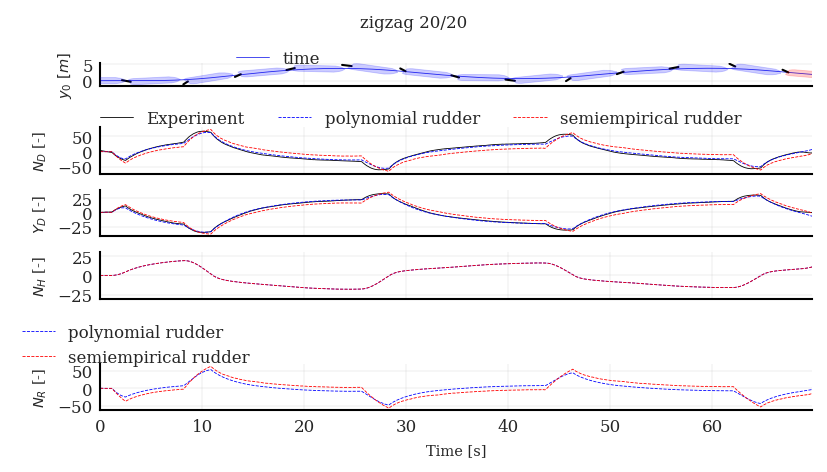

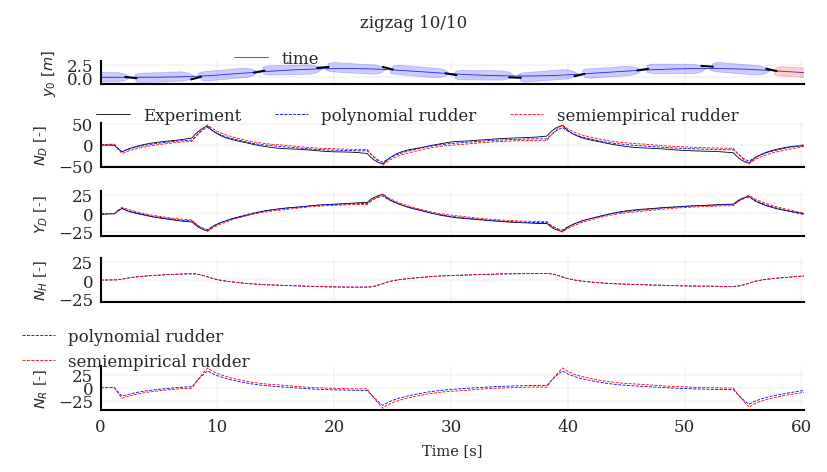

In [7]:
for id, meta_data in meta_datas.iterrows():

    df_EKF_smooth = catalog.load("wPCC.tests_ek_smooth1")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)
    df_EKF_smooth['thrust'] = df_EKF_smooth['thrust_port'] + df_EKF_smooth['thrust_stbd']
    #data = load(id=id, catalog=catalog, smooth=False)
    #data = filter(data,cutoff=1)
    #data = data.iloc[100:-100].copy()

    if id==22774:
        #data=data.loc[0:70].copy()
        df_EKF_smooth = df_EKF_smooth.loc[0:70].copy()


    fig = plot_compare_model_forces(model=models['polynomial rudder'], models=models, data=df_EKF_smooth, styles=styles, keys=['N_D','Y_D','N_H','N_R'], delta_corners=False);
    #fig = plot_compare_model_forces(model=models["ID small"], models=models, data=df_EKF_smooth, styles=styles, keys=['N_VCT','Y_VCT','N_H','N_R'], delta_corners=False);
    
    fig.axes[-1].legend(loc='upper center', bbox_to_anchor=(0.05, 2.2), ncol=1)
    fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.25, 2.2), ncol=3)
    fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.45, 1.70), ncol=3)
    #fig.axes[1].legend(bbox_to_anchor=(0.7, 1.5), ncol=5)
    #fig.axes[1].legend(ncol=3)
    
    for ax in fig.axes[1:5]:
        ylims = ax.get_ylim()
        ylims = [min([ylims[0],-30]), max([ylims[1],30]),]
        ax.set_ylim(ylims)

    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
    fig.suptitle(name)

    file_name = name.replace("/","_")
    paper.save_fig(fig, f"{file_name}.svg")


## Closed loop simulation

[11/11/24 10:13:04] INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=879744;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=478964;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=163452;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=562288;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=532117;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=330081;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=57978;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=340478;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/11/24 10:13:05] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=900091;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=771751;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=735354;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=77699;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/11/24 10:17:25] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=120008;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=392302;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/11/24 10:17:26] WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=872499;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=729019;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:133: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=890463;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=202061;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=668387;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=579631;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/11/24 10:17:27] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=149385;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=754543;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=950487;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=923877;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=748586;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=412640;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/11/24 10:17:28] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=681004;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=223173;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/11/24 10:17:29] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=466380;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=801857;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/11/24 10:17:30] WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=404470;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=963276;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:133: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

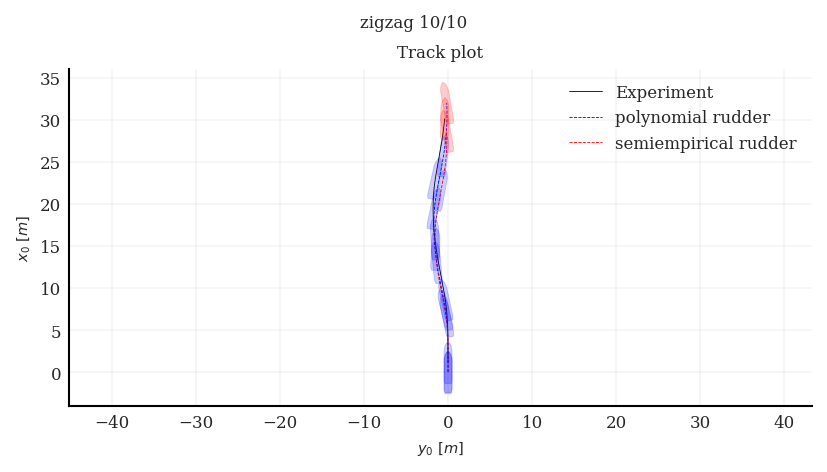

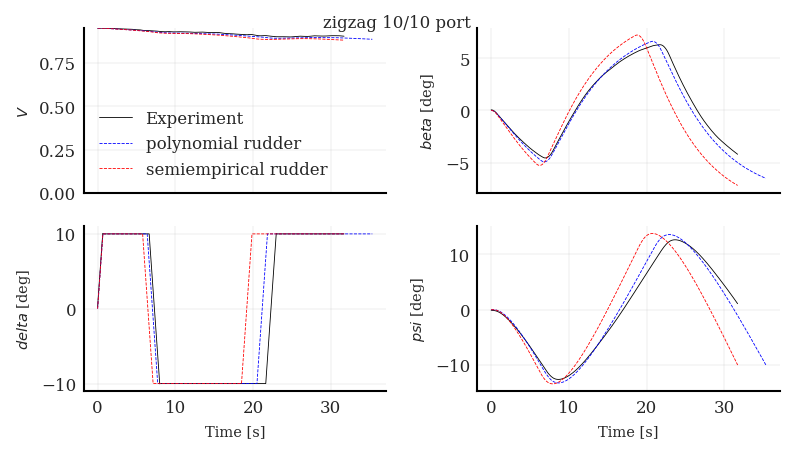

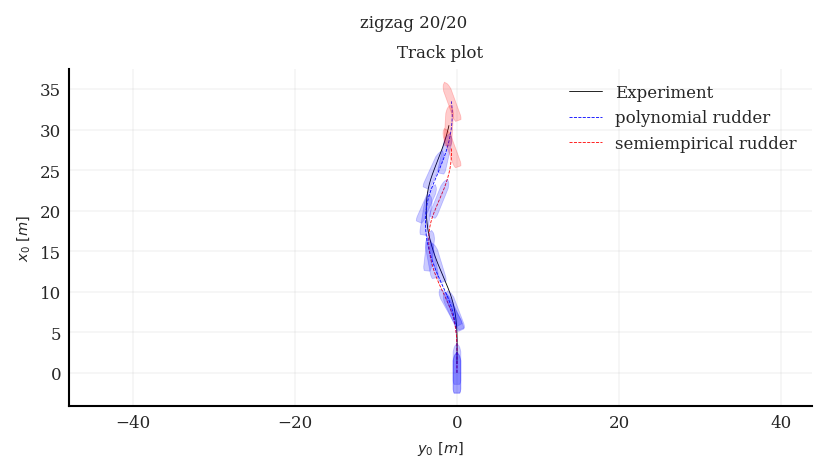

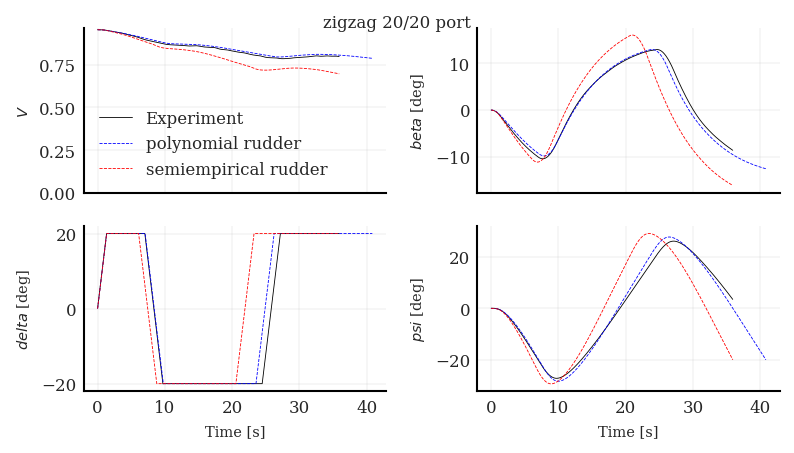

In [8]:
for angle, group in meta_datas.groupby(by='angle1'):

    fig,ax=plt.subplots()
    include_label=True
    
    for id, meta_data in group.iterrows():
    
        df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
        df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)
    
        dataframes = {'Experiment':df_EKF_smooth}
        
        for model_name, model in models.items():
        
            data = preprocess(df_EKF_smooth,ship_data=model.ship_parameters)
            angle = zigzag_angle(data_MDL=data)
        
            df_simulation = simulate_closed_loop(model=model,data=data)
        
            direction = "port" if angle > 0 else "stbd"
            name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction} {model_name}"
        
            dataframes[model_name] = df_simulation

        dataframes['Experiment'] = dataframes['Experiment'].loc[-1:df_simulation.index[-1]].copy()
        
        track_plots(dataframes, lpp=model.ship_parameters['L'], beam=model.ship_parameters['B'], include_wind=False, styles=styles, ax=ax, include_label=include_label);
        fig = ax.get_figure()
        direction = "port" if angle > 0 else "stbd"
        name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
        fig.suptitle(name)
        file_name = name.replace("/","_")
        paper.save_fig(fig, f"track plot {file_name}.svg")
        
        fig = plot(dataframes, keys=['psi','beta','V','delta'], units=units, styles=styles, ncols=2, include_label=include_label);
        name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction}"
        fig.suptitle(name)
        file_name = name.replace("/","_")
        paper.save_fig(fig, f"closed loop {file_name}.svg")
        
        
        include_label=False